In [184]:
import numpy
from typing import List

from objects import NormalModel, TransitionDensity
from utils import rand_obs, rand_nnd, model_extract
import matplotlib.pyplot as plt
from numpy import ndarray as Array
from funcs import forward, backward
from memory import DLModelMemory

In [185]:
# Dimensional parameters
n: "int" = 1
m: "int" = 1
p: "int" = 3

# Model's observable period
period: "int" = 100

# Primordial model setting
n0: "NormalModel" = rand_obs((p,n))
n0.covariance = rand_nnd(p, 1)

# Evolver setting
b_e: "Array" = numpy.zeros((p, n)) # p by n
a_e: "Array" = numpy.array([[1,1,0],[0,1,0],[0,0,1]]) # p by p
v_e: "Array" = numpy.eye(p) * 1
te: "TransitionDensity" = TransitionDensity(b_e, a_e, v_e)

# Predictor setting
b_p: "Array" = numpy.zeros((m, n)) # m by n
a_p: "Array" = numpy.array([[1,0,0]]) # m by p
v_p: "Array" = numpy.eye(m) * 50
tp: "TransitionDensity" = TransitionDensity(b_p, a_p, v_p)

memory: "DLModelMemory" = DLModelMemory()

In [186]:
memory = forward(
    period=period,
    m=m,
    n=n,
    n0=n0,
    te=te,
    tp=tp,
    memory=memory
)
memory = backward(
    period=period,
    tp=tp,
    memory=memory
)

TypeError: forward() got an unexpected keyword argument 'memory'

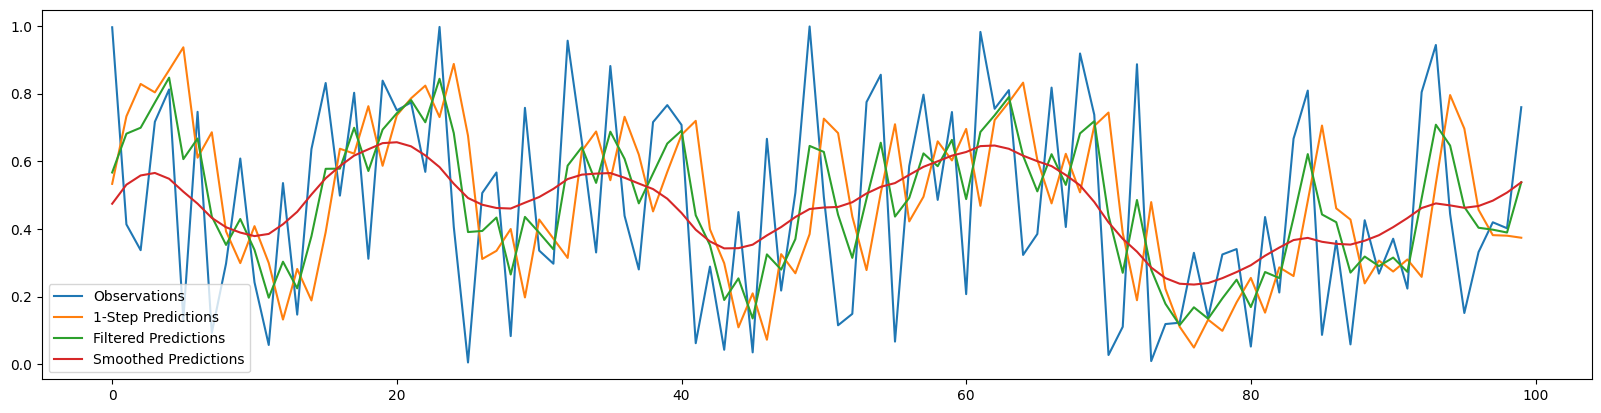

In [ ]:
fig, ax = plt.subplots()
x_data = list(range(period))
y1_data = list(model_extract(memory.o2))
y2_data = list(model_extract(memory.e2))
y3_data = list(model_extract(memory.f2))
y4_data = list(model_extract(memory.s2))
ax.plot(x_data, y1_data, label="Observations")
ax.plot(x_data, y2_data, label="1-Step Predictions")
ax.plot(x_data, y3_data, label="Filtered Predictions")
ax.plot(x_data, y4_data, label="Smoothed Predictions")
ax.legend()
fig.set_figwidth(20)
plt.show()